In [6]:
import os
import json
import cv2
from tqdm import tqdm

# Paths
image_dir = r"C:\Users\ADAPA SUNIL KUMAR\Desktop\AIG FOOD PROJECT\171_images\images\Train"
annotation_file = r"C:\Users\ADAPA SUNIL KUMAR\Desktop\AIG FOOD PROJECT\171_images\annotations\instances_Train.json"
output_dir = r"C:\Users\ADAPA SUNIL KUMAR\Desktop\AIG FOOD PROJECT\171_images\output"

# Load COCO JSON
with open(annotation_file) as f:
    data = json.load(f)

# Maps for lookup
image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
category_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

# Group annotations by image_id
from collections import defaultdict
image_annotations = defaultdict(list)
for ann in data['annotations']:
    image_annotations[ann['image_id']].append(ann)

# Process each image
for image_id, anns in tqdm(image_annotations.items()):
    img_path = os.path.join(image_dir, image_id_to_filename[image_id])
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not read {img_path}")
        continue


    for idx, ann in enumerate(anns):
        x, y, w, h = map(int, ann['bbox'])
        category = category_id_to_name[ann['category_id']]

        patch = img[y:y+h, x:x+w]

        # Save patch
        category_folder = os.path.join(output_dir, category)
        os.makedirs(category_folder, exist_ok=True)

        patch_filename = f"{os.path.splitext(image_id_to_filename[image_id])[0]}_patch{idx}.jpg"
        patch_path = os.path.join(category_folder, patch_filename)
        cv2.imwrite(patch_path, patch)

print("✅ All patches saved by label!")
print(img_path)


100%|██████████| 171/171 [00:38<00:00,  4.47it/s]

✅ All patches saved by label!
C:\Users\ADAPA SUNIL KUMAR\Desktop\AIG FOOD PROJECT\171_images\images\Train\yellow dal.jpg


In [3]:
!pip install pycocotools

  Using cached pycocotools-2.0.10-cp312-abi3-win_amd64.whl.metadata (1.3 kB)
Using cached pycocotools-2.0.10-cp312-abi3-win_amd64.whl (76 kB)


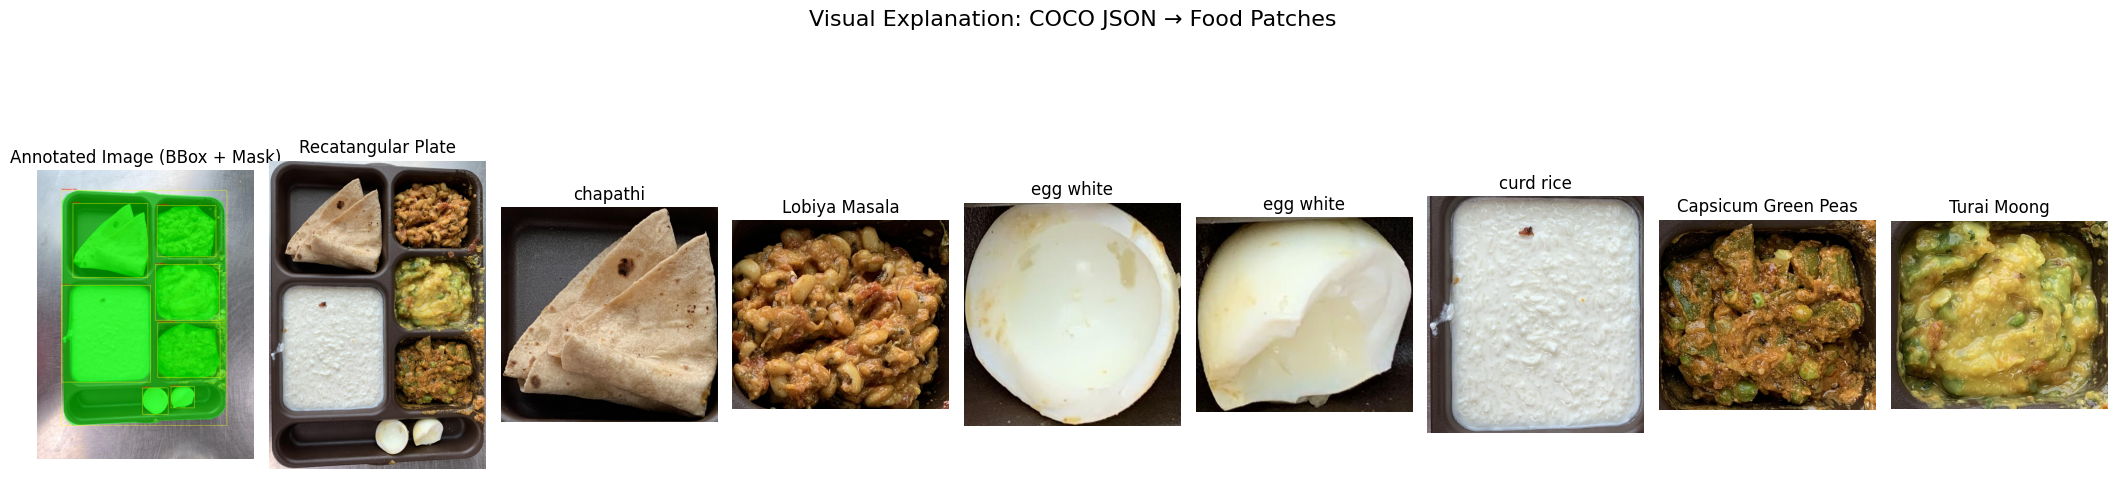

In [8]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict
from pycocotools import mask as maskUtils

# Paths
image_dir = r"C:\Users\ADAPA SUNIL KUMAR\Desktop\AIG FOOD PROJECT\21_images_rec\images\default"
annotation_file = r"C:\Users\ADAPA SUNIL KUMAR\Desktop\AIG FOOD PROJECT\21_images_rec\annotations\instances_default.json"

# Load COCO annotation
with open(annotation_file) as f:
    data = json.load(f)

# Lookup dictionaries
image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
category_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

# Group annotations by image_id
image_annotations = defaultdict(list)
for ann in data['annotations']:
    image_annotations[ann['image_id']].append(ann)

# Select a random image
selected_image_id = random.choice(list(image_annotations.keys()))
image_filename = image_id_to_filename[selected_image_id]
image_path = os.path.join(image_dir, image_filename)

# Read and convert image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"❌ Image not found: {image_path}")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Copy for drawing
annotated_image = image_rgb.copy()
anns = image_annotations[selected_image_id]
patches = []
titles = []

# Visualize BBox + Mask
for idx, ann in enumerate(anns):
    x, y, w, h = map(int, ann['bbox'])
    category = category_id_to_name[ann['category_id']]

    # Draw BBox
    cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (255, 255, 0), 3)  # Yellow box
    cv2.putText(annotated_image, category, (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    # Optional: Mask overlay
    if 'segmentation' in ann and ann['segmentation']:
        rle = maskUtils.frPyObjects(ann['segmentation'], image.shape[0], image.shape[1])
        mask = maskUtils.decode(rle)
        if len(mask.shape) == 3:
            mask = np.any(mask, axis=2)

        green_mask = np.zeros_like(image_rgb, dtype=np.uint8)
        green_mask[:] = [0, 255, 0]  # Green
        annotated_image = np.where(mask[:, :, None], cv2.addWeighted(annotated_image, 0.5, green_mask, 0.5, 0), annotated_image)

    # Extract patch
    patch = image_rgb[y:y + h, x:x + w]
    patches.append(patch)
    titles.append(f"{category}")

# --- Plot Section ---
n_patches = len(patches)
fig = plt.figure(figsize=(5 + n_patches * 2, 6))

# Original image with annotation
plt.subplot(1, n_patches + 1, 1)
plt.imshow(annotated_image)
plt.title("Annotated Image (BBox + Mask)")
plt.axis('off')

# Extracted patches
for i, patch in enumerate(patches):
    plt.subplot(1, n_patches + 1, i + 2)
    plt.imshow(patch)
    plt.title(titles[i])
    plt.axis('off')

plt.suptitle("Visual Explanation: COCO JSON → Food Patches", fontsize=16)
plt.tight_layout()
plt.show()


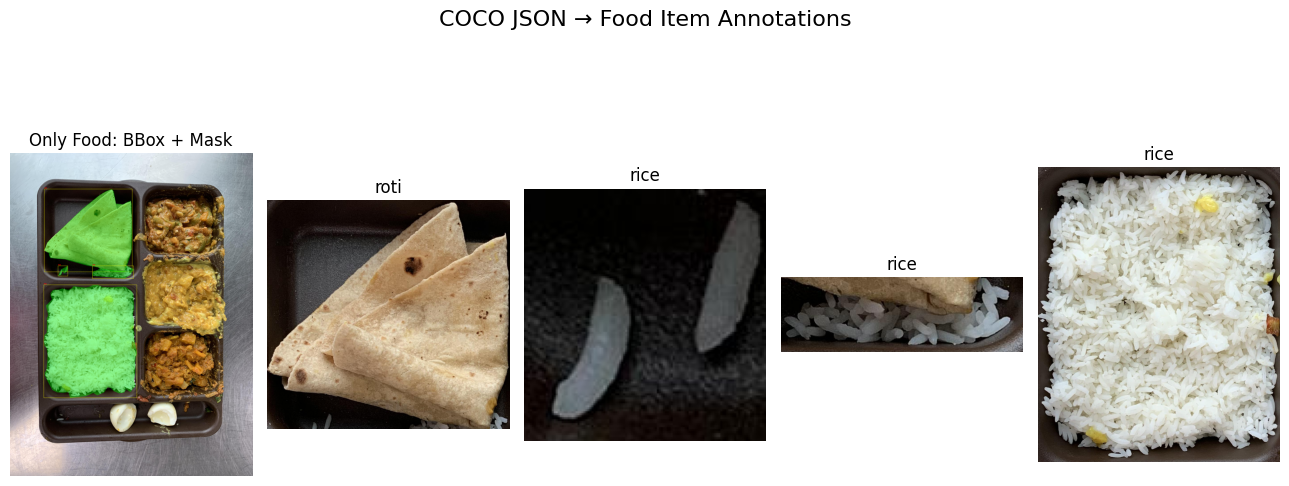

In [13]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict
from pycocotools import mask as maskUtils

# === Paths ===
image_dir = r"C:\Users\ADAPA SUNIL KUMAR\Desktop\AIG FOOD PROJECT\21_images_rec\images\default"
annotation_file = r"C:\Users\ADAPA SUNIL KUMAR\Desktop\AIG FOOD PROJECT\21_images_rec\annotations\instances_default.json"

# === Load COCO JSON ===
with open(annotation_file) as f:
    data = json.load(f)

image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
category_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

# === Choose which categories are FOOD ===
food_categories = {
    "idly", "chapati", "roti", "paratha", "rice", "sambar", "curry", "dal", "curd","egg white" "vegetable", "bhindi", "pumpkin", "brinjal",
    "cauliflower", "cabbage", "potato", "paneer", "biryani", "dosa", "upma", "pongal",
    "lemon rice", "tomato rice", "coconut chutney", "sambar rice", "curd rice",
    "rasam", "green peas", "capsicum", "chicken", "fish", "mutton", "pickle", "sweet"
}  # Example
food_category_ids = {cat['id'] for cat in data['categories'] if cat['name'].lower() in food_categories}

# === Group annotations by image_id ===
image_annotations = defaultdict(list)
for ann in data['annotations']:
    if ann['category_id'] in food_category_ids:
        image_annotations[ann['image_id']].append(ann)

# === Pick one annotated image with food ===
valid_image_ids = list(image_annotations.keys())
selected_image_id = random.choice(valid_image_ids)
image_filename = image_id_to_filename[selected_image_id]
image_path = os.path.join(image_dir, image_filename)

# === Load and prepare image ===
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"❌ Image not found: {image_path}")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
annotated_image = image_rgb.copy()

anns = image_annotations[selected_image_id]
patches = []
titles = []

# === Draw only FOOD item boxes and masks ===
for idx, ann in enumerate(anns):
    x, y, w, h = map(int, ann['bbox'])
    category = category_id_to_name[ann['category_id']]

    # --- Draw mask if present ---
    if 'segmentation' in ann and ann['segmentation']:
        rle = maskUtils.frPyObjects(ann['segmentation'], image.shape[0], image.shape[1])
        mask = maskUtils.decode(rle)
        if len(mask.shape) == 3:
            mask = np.any(mask, axis=2)

        green_mask = np.zeros_like(image_rgb, dtype=np.uint8)
        green_mask[:] = [0, 255, 0]  # Green
        annotated_image = np.where(mask[:, :, None], cv2.addWeighted(annotated_image, 0.6, green_mask, 0.4, 0), annotated_image)

    # --- Draw bounding box and label ---
    cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (255, 255, 0), 2)
    cv2.putText(annotated_image, category, (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # --- Crop the patch ---
    patch = image_rgb[y:y + h, x:x + w]
    patches.append(patch)
    titles.append(category)

# === Plot annotated image and extracted patches ===
fig = plt.figure(figsize=(5 + len(patches) * 2, 6))

# Annotated image
plt.subplot(1, len(patches) + 1, 1)
plt.imshow(annotated_image)
plt.title("Only Food: BBox + Mask")
plt.axis('off')

# Show patches
for i, patch in enumerate(patches):
    plt.subplot(1, len(patches) + 1, i + 2)
    plt.imshow(patch)
    plt.title(titles[i])
    plt.axis('off')

plt.suptitle("COCO JSON → Food Item Annotations", fontsize=16)
plt.tight_layout()
plt.show()
